In [156]:
import numpy as np
import matplotlib.pyplot as plot
import math
import pandas

In [157]:
class currents:
    def I_sine(t):
        return 20* (math.sin(t*0.5) + 1.5)

    def I_constant(t):
        return 50

    def I_constant_2(t):
        return 70
        
    def I_constant_3(t):
        return 90

    def I_step(t):
        if t > 20 and t <= 50:
            return 0
        return 5    

    def I_linear(t):
        return 10*t - 2.5  

    def I_polonomyal(t):
        return 2*(t**2) - 3*t + 5

In [158]:
class LIF:
    def __init__(self, I, T=100, dt=0.1,V_threshold=-50, V_rest=-70, V=-100, V_reset=-65, V_spike=10, g=10, 
    tau=8, tau_k=1, neuron_type='excitatory') :
        self.T = T
        self.dt = dt
        self.tau = tau
        self.tau_k = tau_k
        self.g = g
        self.V_rest = V_rest
        self.V_threshold = V_threshold
        self.V_reset = V_reset
        self.V_spike = V_spike
        self.max_currents = {}
        self.neuron_type = neuron_type
        self.times = []
        self.I = I
        self.V = V
        self.count = 0
        self.V_t = []

    def start(self):
        t = 0
        while t <= self.T:
            du = (-(self.V - self.V_rest) + self.I(t) * self.g)* (self.dt/self.tau)

            self.V += du * self.dt
            is_spike = False
            if self.V >= self.V_threshold:
                self.V_t.append(self.V + self.V_spike)
                self.count += 1
                self.V = self.V_reset
                is_spike = True

            else:
                self.V_t.append(self.V)
            t += self.dt

            yield {'u': self.V, 'is_spike': is_spike}

    def V_plot(self):
        plot.plot(list(map(lambda i: i * self.dt, range(len(self.V_t)))), self.V_t)
        plot.show()

    def V_t(self, times, I):
        V=[]
        V.append(self.V_rest)
        self.max_currents[str(I.__name__)] = I(times[0])
        for i in range(1, len(times)):
            if I(times[i]) > self.max_currents[str(I.__name__)]:
                self.max_currents[str(I.__name__)] = I(times[i])
            V.append(((-1 * (V[i-1]- self.V_rest)) + (self.R * I(times[i])) * self.dt/self.tau)+ V[i-1])
            if V[i] >= self.V_threshold:
                    V[i] = self.V_rest
                    V[i-1] = self.V_spike
        return V            
        
        
    def plot(self, I):
        self.times = np.linspace(0, self.T, int(self.T/self.dt))
        plot.figure(figsize=(15, 10))
        plot.title('LIF')
        plot.suptitle("R: " + str(self.R) + "\ntotal time: " + str(self.T) + "\ndt: " + str(self.dt) +
                    "\nV_threshold: " + str(self.V_threshold) + "\nV_rest: " + str(self.V_rest) + "\nV_spike: " + str(self.V_spike) + 
                    "\nI: " + (str(I.__name__)), fontsize=12, ha = 'left', x=0.95, y=1)        
        plot.plot(self.times, self.V_t(self.times, I))
        plot.xlabel('Time(t)')
        plot.ylabel('Potential(v)')
        plot.show()           

In [159]:
class STDP_learning:
    def __init__(self, neurons, connections, weights, t_delay, count):
        self.neurons = neurons
        self.connections = connections
        self.weights = weights
        self.t_delay = t_delay
        self.count = count
        
        self.neuron_actions = self.init_actions(neurons)
        self.w_t = [[0] * self.count for _ in range(len(connections))]

        self.spikes = []
        self.spikes_effect = []
        self.t_spikes = []
        self.dt = []

    def init_actions(self, neurons):
        self.neuron_actions = []
        for neuron in neurons:
            self.neuron_actions.append(neuron.start()) 
        return self.neuron_actions    
        
    def start(self):
        self.spikes_effect = [[0] * len(self.neurons) for _ in range(self.count)]
        for i in range(self.count):
            self.dt.append(i)
            
            for j in range(len(self.neuron_actions)):
                info = next(self.neuron_actions[j])
                if info['is_spike']:
                    self.spikes.append(j+1)
                    self.t_spikes.append(i)
                    x = 0
                    for connection in self.connections:
                        if connection[0] == j+1:
                            if i+self.t_delay < self.count:
                                self.spikes_effect[i + self.t_delay][connection[1]-1] += self.weights[x]

                            spike_x = len(self.spikes)-1
                            for spike in reversed(self.spikes):
                                if spike == connection[1]:
                                    dtpp = self.t_spikes[spike_x] - i
                                    self.weights[x] = self.weights[x] + 25*math.exp(-abs(dtpp)/5)
                                    break
                                spike_x -= 1

                        elif connection[1] == j+1:
                            for spike in reversed(self.spikes):
                                if spike == connection[0]:
                                    dtpp = i - self.t_spikes[spike_x]
                                    self.weights[x] = self.weights[x] - 25*math.exp(-abs(dtpp)/5)
                                    break
                        x += 1

                connection_x = 0
                for count in self.weights:
                    self.w_t[connection_x][i] = self.weights[connection_x]
                    connection_x += 1

            for k in range(len(self.neurons)):
                self.neurons[k].V += self.spikes_effect[i][k]
        print(self.weights)
      
    def u_plot(self):
        legend = []
        for i in range(len(self.neurons)):
            plot.plot(list(map(lambda j: j * self.neurons[i].dt, range(len(self.neurons[i].V_t)))), self.neurons[i].V_t)
            legend.append('Neuron ' + str(i+1))
        plot.legend(legend)
        
    def scatter_plot(self):
        plot.scatter(self.t_spikes, self.spikes)
        
    def w_t_plot(self, pre, post):
        i = 0
        for connection in self.connections:
            if connection[0] == pre and connection[1] == post:
                break
            i += 1
        plot.plot(self.dt, self.w_t[i])

In [160]:
neuron1 = LIF(I=currents.I_constant)
neuron2 = LIF(I=currents.I_constant)
neuron3 = LIF(I=currents.I_constant_3)

neurons = [neuron1, neuron2, neuron3]
connections = [(1, 2), (1, 3), (2, 1), (2, 3), (3, 1), (3, 2)]
weights = [3, 3, 3, 3, 3, 3]
stdp = STDP_learning(neurons, connections, weights, 2, 500)
stdp.start()

[-53.25635623956204, 210.89667186972417, 796.9285249668976, -8.25747258346852, 828.8902524073017, 890.8828118762074]


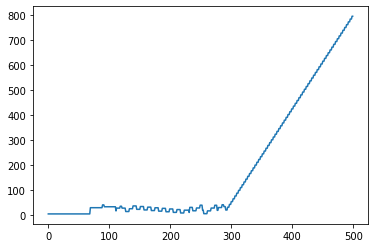

In [161]:
stdp.w_t_plot(2, 1)

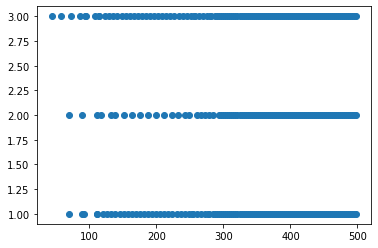

In [162]:
stdp.scatter_plot()

[-10.25791579482502, 344.77719443795746, -726.9614353342272, -385.1842408962688, 26.56682277162256, -10.717758978161594]


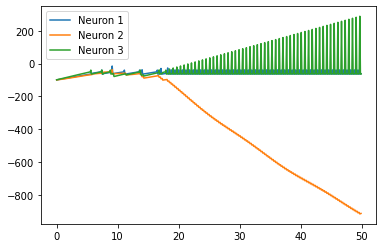

In [163]:
neuron1 = LIF(I=currents.I_constant)
neuron2 = LIF(I=currents.I_sine)
neuron3 = LIF(I=currents.I_constant_2)

neurons = [neuron1, neuron2, neuron3]
connections = [(1, 2), (1, 3), (2, 1), (2, 3), (3, 1), (3, 2)]
weights = [3, 3, 3, 3, 3, 3]
stdp = STDP_learning(neurons, connections, weights, 2, 500)
stdp.start()
stdp.u_plot()

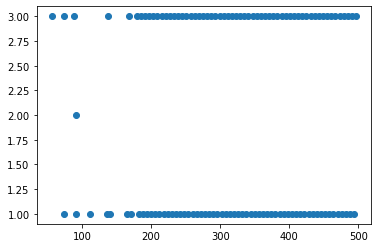

In [164]:
stdp.scatter_plot()

[-18.59366622263158, -21.160008432329203, -219.4566094867555, -22.0, 15.880299334679867, 3.0]


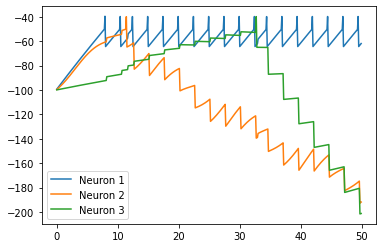

In [165]:
neuron1 = LIF(I=currents.I_constant)
neuron2 = LIF(I=currents.I_sine)
neuron3 = LIF(I=currents.I_step)

neurons = [neuron1, neuron2, neuron3]
connections = [(1, 2), (1, 3), (2, 1), (2, 3), (3, 1), (3, 2)]
weights = [3, 3, 3, 3, 3, 3]
stdp = STDP_learning(neurons, connections, weights, 2, 500)
stdp.start()
stdp.u_plot()

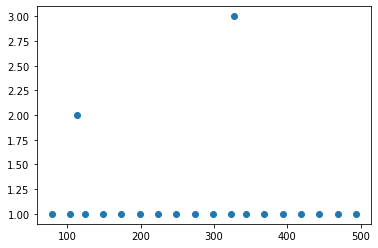

In [166]:
stdp.scatter_plot()

In [167]:
data = pandas.read_excel('./CN_3_DATASET.xlsx')
data

,test,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10
0,inpput_neuron_number,train_1,train_2,train_3,train_4,train_5,train_6,train_7,train_8,train_9,train_10
1,1,1,2,3,2,1,1,0,0,0,2
2,2,1,1,1,0,1,0,1,0,0,2
3,3,0,1,0,0,0,0,0,0,0,2
4,4,0,0,0,0,0,0,3,1,0,1
5,5,0,0,0,0,1,2,0,1,1,2
6,output_neuron_number,1,1,1,1,1,0,0,0,0,1
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,test,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,inpput_neuron_number,train_1,train_2,train_3,train_4,train_5,train_6,train_7,train_8,train_9,train_10


In [168]:
class RSTDP_learning:
    def __init__(self, neurons, connections, weights ,t_delay, count, layer, target_neuron, type):
        self.neurons = neurons
        self.connections = connections
        self.weights = weights
        self.t_delay = t_delay
        self.count = count
        self.type = type
        self.layer = layer
        self.target_neuron = target_neuron

        self.neuron_actions = self.init_actions(neurons)
        self.w_t = [[0] * self.count for _ in range(len(connections))]
    
        self.spikes = []
        self.t_spikes = []
        self.dt = []
        self.spikes_effect = []
        self.spikes_effect = [[0] * len(self.neurons) for _ in range(self.count)]


    def init_actions(self, neurons):
        self.neuron_actions = []
        for neuron in neurons:
            self.neuron_actions.append(neuron.start()) 
        return self.neuron_actions  
    
    def start(self):
        for i in range(self.count):
            self.dt.append(i)
      
            for j in range(len(self.neuron_actions)):
                info = next(self.neuron_actions[j])
                if info['is_spike']:
                    if j+1 in self.layer:
                        if self.type == 'train':
                            if j+1 == self.target_neuron:
                                DA = 10
                            else:
                                DA = 1/2
                            connection_x = 0
                            for count in self.weights:
                                self.weights[connection_x] *= DA
                                connection_x += 1
                        if self.type == 'test':
                            return self.weights, i, j+1 == self.target_neuron
                    self.spikes.append(j + 1)
                    self.t_spikes.append(i)
                    x = 0
                    for connection in self.connections:
                        if connection[0] == j+1:                            
                            if i+self.t_delay < self.count:
                                self.spikes_effect[i + self.t_delay][connection[1]-1] += self.weights[x]
                            if self.type == 'train':
                                spike_x = len(self.spikes)-1
                                for spike in reversed(self.spikes):
                                    if spike == connection[1]:
                                        dtpp = self.t_spikes[spike_x] - i
                                        self.weights[x] = self.weights[x] + 25*math.exp(-abs(dtpp)/5)
                                        break
                                    spike_x -= 1
                        elif connection[1] == j+1:
                            if self.type == 'train':
                                for spike in reversed(self.spikes):
                                    if spike == connection[0]:
                                        dtpp = i - self.t_spikes[spike_x]
                                        self.weights[x] = self.weights[x] - 25*math.exp(-abs(dtpp)/5)
                                        break
                        x += 1
                connection_x = 0
                for count in self.weights:
                    self.w_t[connection_x][i] = self.weights[connection_x]
                    connection_x += 1

            for k in range(len(self.neurons)):
                self.neurons[k].V += self.spikes_effect[i][k]

        if self.type == 'train':
            return self.weights, self.count
        else: 
            return self.weights, self.count, False

In [169]:
def train(number, weights, neurons, connections, target_neuron, layer):

    return weights


In [170]:
train_list = [([1,1,0,0,0], 1), 
              ([2,1,1,0,0], 1), 
              ([3,1,0,0,0], 1), 
              ([2,0,0,0,0], 1), 
              ([1,1,0,0,1], 0), 
              ([1,0,0,0,2], 0), 
              ([0,1,0,3,0], 0), 
              ([0,0,0,1,1], 0), 
              ([0,0,0,0,1], 0), 
              ([2,2,2,1,2], 1)]

In [171]:
weights = []
number = 1
connections =  [(1, 6), (1, 7), (2, 6), (2, 7), (3, 6), (3, 7), (4, 6), (4, 7), (5, 6), (5, 7)]
for data in train_list:
    neurons = []
    for count in range(5):
        neurons.append(LIF(I=lambda x: data[0][count]*10))
    for count in range(2):
        neurons.append(LIF(I=lambda x: 0))
    if number == 1:
        weights = [20, 20, 20, 20, 20, 20, 20, 20, 20, 20]
    rstdp = RSTDP_learning(neurons, connections, weights, 2, 500, [6,7], data[1] ,'train')
    weights, ending_count = rstdp.start()
    print(weights)
    number += 1

[-7.5, -20.0, -7.5, -20.0, -7.5, -20.0, -7.5, -20.0, -7.5, -20.0]
[-7.5, -20.0, -7.5, -20.0, -7.5, -20.0, -7.5, -20.0, -7.5, -20.0]
[-7.5, -20.0, -7.5, -20.0, -7.5, -20.0, -7.5, -20.0, -7.5, -20.0]
[-7.5, -20.0, -7.5, -20.0, -7.5, -20.0, -7.5, -20.0, -7.5, -20.0]
[-7.5, -20.0, -7.5, -20.0, -7.5, -20.0, -7.5, -20.0, -7.5, -20.0]
[-7.5, -20.0, -7.5, -20.0, -7.5, -20.0, -7.5, -20.0, -7.5, -20.0]
[-7.5, -20.0, -7.5, -20.0, -7.5, -20.0, -7.5, -20.0, -7.5, -20.0]
[-7.5, -20.0, -7.5, -20.0, -7.5, -20.0, -7.5, -20.0, -7.5, -20.0]
[-7.5, -20.0, -7.5, -20.0, -7.5, -20.0, -7.5, -20.0, -7.5, -20.0]
[-7.5, -20.0, -7.5, -20.0, -7.5, -20.0, -7.5, -20.0, -7.5, -20.0]


In [172]:
test_list = [([1,0,0,0,0], 1), 
             ([0,1,0,0,0], 1), 
             ([0,2,0,0,0], 1), 
             ([2,2,1,0,0], 1), 
             ([1,2,0,0,0], 1), 
             ([1,0,0,0,3], 0), 
             ([3,1,0,2,3], 0), 
             ([0,0,2,2,2], 0), 
             ([1,2,0,1,1], 1), 
             ([2,2,2,3,3], 0)]

In [173]:
weights = []
number = 1
connections =  [(1, 6), (1, 7), (2, 6), (2, 7), (3, 6), (3, 7), (4, 6), (4, 7), (5, 6), (5, 7)]
for data in train_list:
    neurons = []
    for count in range(5):
        neurons.append(LIF(I=lambda x: data[0][count]*10))
    for count in range(2):
        neurons.append(LIF(I=lambda x: 0))
    if number == 1:
        weights = [20, 20, 20, 20, 20, 20, 20, 20, 20, 20]
    rstdp = RSTDP_learning(neurons, connections, weights, 2, 500, [6,7], data[1]+6 ,'test')
    weights, ending_count, last_spike = rstdp.start()
    print(last_spike)
    print(weights)
    number += 1

False
[20, 20, 20, 20, 20, 20, 20, 20, 20, 20]
False
[20, 20, 20, 20, 20, 20, 20, 20, 20, 20]
False
[20, 20, 20, 20, 20, 20, 20, 20, 20, 20]
False
[20, 20, 20, 20, 20, 20, 20, 20, 20, 20]
True
[20, 20, 20, 20, 20, 20, 20, 20, 20, 20]
False
[20, 20, 20, 20, 20, 20, 20, 20, 20, 20]
True
[20, 20, 20, 20, 20, 20, 20, 20, 20, 20]
False
[20, 20, 20, 20, 20, 20, 20, 20, 20, 20]
False
[20, 20, 20, 20, 20, 20, 20, 20, 20, 20]
False
[20, 20, 20, 20, 20, 20, 20, 20, 20, 20]
